In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.compose import ColumnTransformer # 允许同时运用不同的预处理步骤到数据集的不同列
from sklearn.preprocessing import OneHotEncoder, StandardScaler # 用于数值型数据的标准化
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, auc# 用于评估模型性能
from sklearn.model_selection import train_test_split, GridSearchCV # 用于划分数据集、模型选择和超参数调优

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from scipy import stats

import warnings

warnings.filterwarnings("ignore")

# 数据导入及处理

In [44]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [45]:
df = pd.read_csv('Customer Churn Dataset.csv')
print('-'*50)
print('数据集存在的重复值个数：', df.duplicated().sum())
print('-'*50)
print('数据集存在的缺失值个数：\n', df.isna().sum())
print('-'*50)
print('数据集信息：')
print(df.info())

--------------------------------------------------
数据集存在的重复值个数： 0
--------------------------------------------------
数据集存在的缺失值个数：
 RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
--------------------------------------------------
数据集信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 

In [46]:
# CustormerId数据类型改为字符类型
df['CustomerId'] = df['CustomerId'].astype('str')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  object 
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 1.1+ MB
None


In [47]:
print('-'*100)
display(df.describe())

----------------------------------------------------------------------------------------------------


,RowNumber,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [48]:
# 对姓氏数据进行脱敏处理
# 只保留首字母，其余用*代替
def anonymize_surname(surname):
    new_surname = surname[0] + '*' * (len(surname)-1)
    return new_surname

In [49]:
df['Surname'] = df['Surname'].map(anonymize_surname)
display(df.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,H*******,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,H***,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,O***,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,B***,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,M*******,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 探索性数据分析

## 描述性可视化

首先分析客户基本信息和流失与否的关系

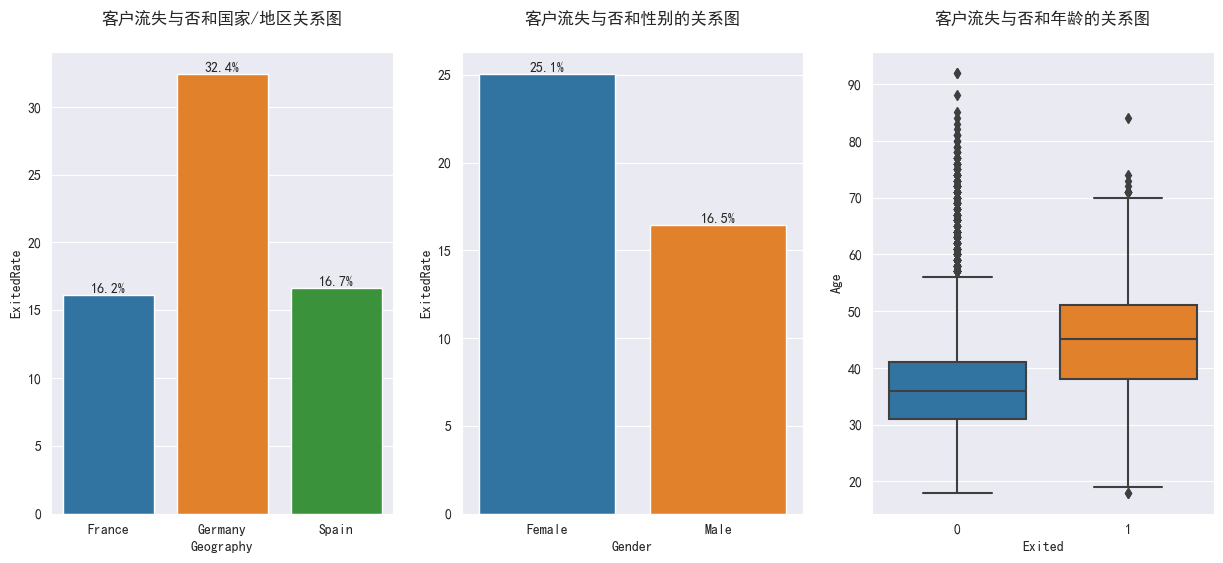

In [50]:
fig = plt.figure(figsize = (15, 6))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

# 客户流失与否和国家/地区的关系
geography_exited_pivot = df.pivot_table(index = 'Geography', columns = 'Exited', aggfunc = 'size', fill_value = 0)
geography_exited_table = geography_exited_pivot.div(geography_exited_pivot.sum(axis = 1), axis = 0) * 100
geography_exited_table = geography_exited_table.reset_index().rename(columns = {0:'NotExitedRate', 1:'ExitedRate'})
# display(geography_exited_table['Geography'])

sns.barplot(x = 'Geography', y = 'ExitedRate', data = geography_exited_table, ax = ax1)
ax1.set_title('客户流失与否和国家/地区关系图', fontsize = 12, pad = 20)
ax1.set_ylabel('ExitedRate')

for bar in ax1.patches:
    x_loc = bar.get_x() + bar.get_width() / 2
    y_loc = bar.get_height()
    ax1.text(x_loc, y_loc, f'{y_loc:.1f}%'.format(y_loc), ha = 'center', va = 'bottom')
# 客户流失与否和性别的关系图
gender_exited_pivot = df.pivot_table(index = 'Gender', columns = 'Exited', aggfunc = 'size', fill_value = 0)
gender_exited_table = gender_exited_pivot.div(gender_exited_pivot.sum(axis = 1), axis = 0) * 100
gender_exited_table = gender_exited_table.reset_index().rename(columns = {0:'NotExitedRate', 1:'ExitedRate'})

sns.barplot(x = 'Gender', y = 'ExitedRate', data = gender_exited_table, ax = ax2)
ax2.set_title('客户流失与否和性别的关系图', fontsize = 12, pad = 20)
ax2.set_ylabel('ExitedRate')
for bar in ax2.patches:
    x_loc = bar.get_x() + bar.get_width() / 2
    y_loc = bar.get_height()
    ax2.text(x_loc, y_loc, f'{y_loc:.1f}%'.format(y_loc), ha = 'center', va = 'bottom')

# 客户流失与否和年龄的关系图
sns.boxplot(x = 'Exited', y = 'Age', data = df, ax = ax3)
ax3.set_title('客户流失与否和年龄的关系图', fontsize = 12, pad = 20)

plt.show()

小结：
1.德国客户的流失率高于其他两个国家客户约一倍

2.女客户的流失率要高于男客户

3.流失客户的平均年龄约为45岁，而非流失客户的平均年龄约为36岁，可能年龄越大就容易流失。

接下来分析客户的财务状况与流失与否的关系

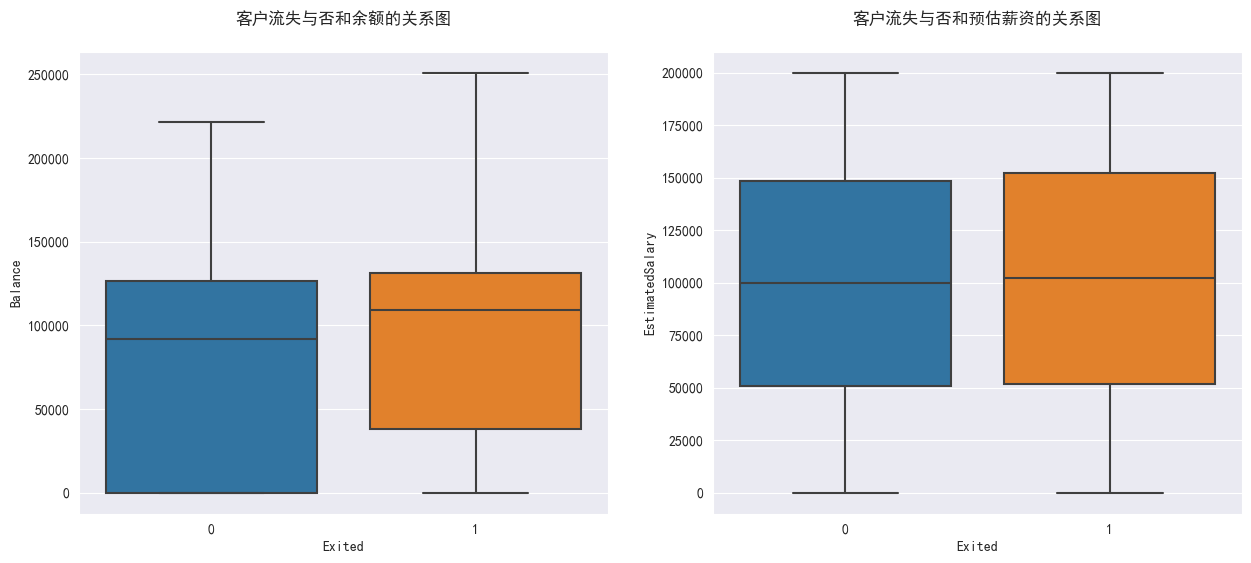

In [51]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.boxplot(x = 'Exited', y = 'Balance', data = df, ax = ax1)
ax1.set_title('客户流失与否和余额的关系图', fontsize = 12, pad = 20)

sns.boxplot(x = 'Exited', y = 'EstimatedSalary', data = df, ax = ax2)
ax2.set_title('客户流失与否和预估薪资的关系图', fontsize = 12, pad = 20)

plt.show()

小结：

1.流失客户的卡上余额高于非流失客户的

2.流失客户和非流失客户的预估工资差别不大，可能相关性不高。

继续分析客户的信用和流失与否的关系图

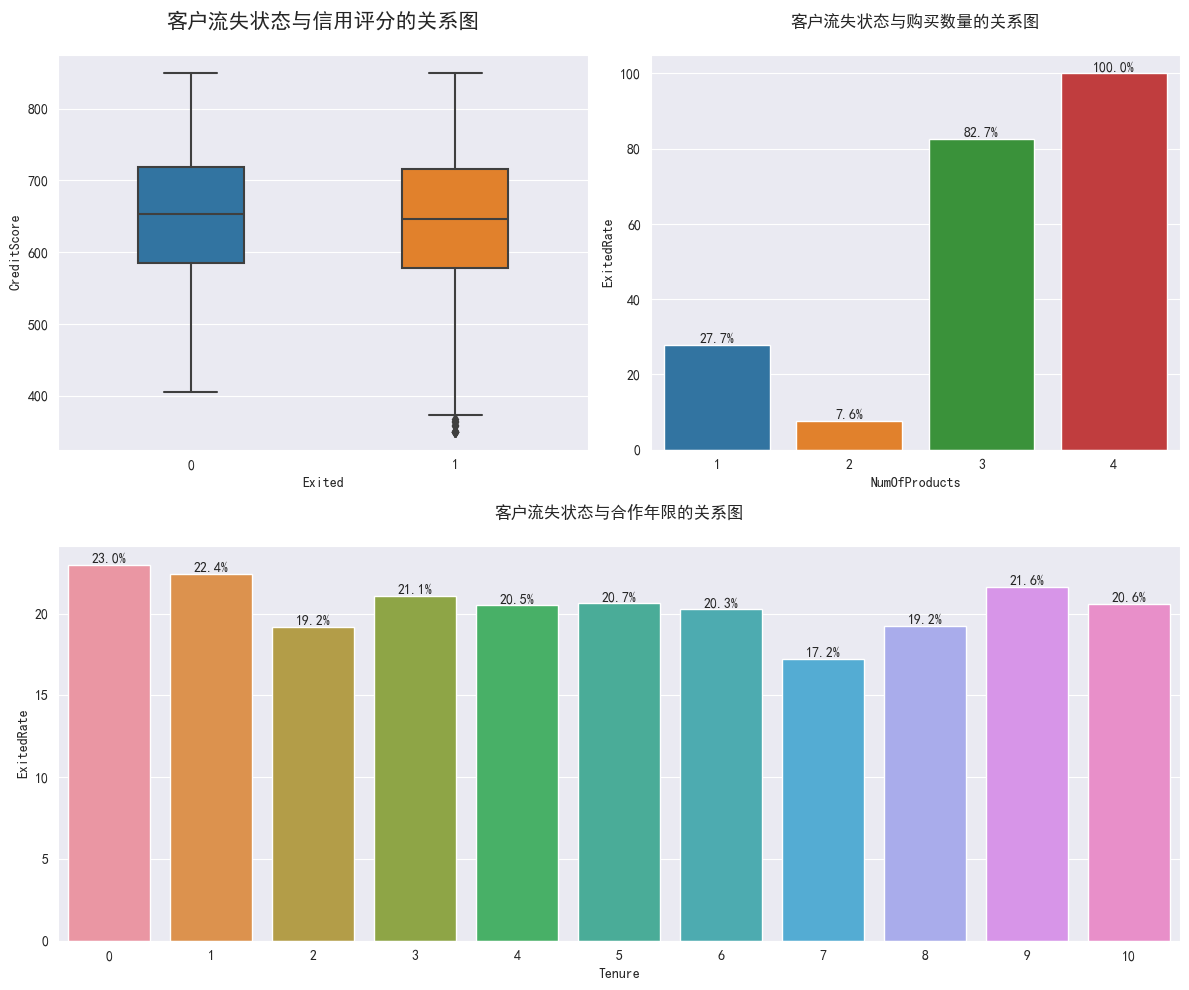

In [52]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,(3,4))

sns.boxplot(x='Exited',y='CreditScore',data=df,width=0.4,ax=ax1)
ax1.set_title('客户流失状态与信用评分的关系图',fontsize=15,pad=20)

# 客户流失状态与购买数量的关系
num_exited_pivot = df.pivot_table(index = 'NumOfProducts',columns = 'Exited',aggfunc='size',fill_value=0)
num_exited_table = num_exited_pivot.div(num_exited_pivot.sum(axis=1),axis=0)*100
num_exited_table = num_exited_table.reset_index().rename(columns={0:'NotExitedRate',1:'ExitedRate'})

sns.barplot(x='NumOfProducts',y='ExitedRate',data=num_exited_table,ax=ax2)
ax2.set_title('客户流失状态与购买数量的关系图',fontsize=12,pad=20)
ax2.set_ylabel('ExitedRate')
for bar in ax2.patches:
    x_loc = bar.get_x() + bar.get_width() / 2
    y_loc = bar.get_height()
    ax2.text(x_loc,y_loc,f'{y_loc:.1f}%',ha='center',va='bottom')

# 客户流失状态与合作年限的关系
tenure_exited_pivot = df.pivot_table(index = 'Tenure', columns='Exited',aggfunc='size',fill_value=0)
tenure_exited_table = tenure_exited_pivot.div(tenure_exited_pivot.sum(axis=1),axis=0)*100
tenure_exited_table = tenure_exited_table.reset_index().rename(columns={0:'NotExitedRate',1:'ExitedRate'})

sns.barplot(x='Tenure',y='ExitedRate',data=tenure_exited_table,ax=ax3)
ax3.set_title('客户流失状态与合作年限的关系图',fontsize=12,pad=20)
ax3.set_ylabel('ExitedRate')
for bar in ax3.patches:
    x_loc = bar.get_x() + bar.get_width()/2
    y_loc = bar.get_height()
    ax3.text(x_loc,y_loc,f'{y_loc:.1f}%',ha='center',va='bottom')

plt.tight_layout()
plt.show()

小结：

1.流失客户和非流失客户的信用评分差不多，可能相关性不高

2.拥有3-4个产品的客户流失率高，可能是银行产品的实际效用未达到客户的期望，导致客户感觉投资回报低。

3.不同合作年限的客户有不同程度的流失率，但差别不是很大，流失率最低为17.2%，最高位23.0%。

继续分析客户的行为与偏好和流失与否的关系

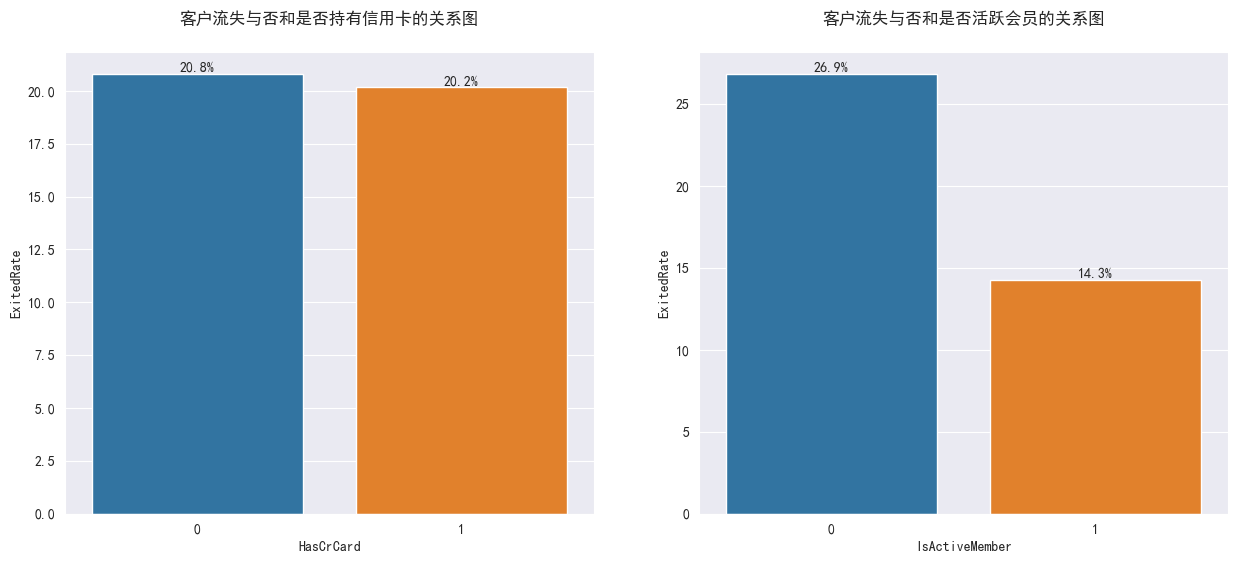

In [53]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# 客户流失与否和是否持有信用卡的关系
card_exited_pivot = df.pivot_table(index='HasCrCard',columns='Exited',aggfunc='size',fill_value=0)
card_exited_table = card_exited_pivot.div(card_exited_pivot.sum(axis=1),axis=0)*100
card_exited_table = card_exited_table.reset_index().rename(columns={0:'NotExitedRate',1:'ExitedRate'})

sns.barplot(x='HasCrCard',y='ExitedRate',data=card_exited_table,ax=ax1)
ax1.set_title('客户流失与否和是否持有信用卡的关系图',fontsize=12,pad=20)
ax1.set_ylabel('ExitedRate')
for bar in ax1.patches:
    x_loc = bar.get_x() + bar.get_width() / 2
    y_loc = bar.get_height()
    ax1.text(x_loc,y_loc,f'{y_loc:.1f}%',ha='center',va='bottom')

# 客户流失与否和是否活跃会员的关系
ac_exited_pivot = df.pivot_table(index='IsActiveMember',columns='Exited',aggfunc='size',fill_value=0)
ac_exited_table = ac_exited_pivot.div(ac_exited_pivot.sum(axis=1),axis=0)*100
ac_exited_table = ac_exited_table.reset_index().rename(columns={0:'NotExitedRate',1:'ExitedRate'})
sns.barplot(x='IsActiveMember',y='ExitedRate',data=ac_exited_table,ax=ax2)
ax2.set_title('客户流失与否和是否活跃会员的关系图',fontsize=12,pad=20)
ax2.set_ylabel('ExitedRate')
for bar in ax2.patches:
    x_loc = bar.get_x() + bar.get_width() / 2
    y_loc = bar.get_height()
    ax2.text(x_loc,y_loc,f'{y_loc:.1f}%',ha='center',va='bottom')

plt.show()

小结：

1.是否拥有信用卡的客户的流失率比较接近

2.非活跃会员的客户流失率较大

## 皮尔逊相关系数

In [54]:
# 计算各个特征与客户流失与否的相关性
# 皮尔逊相关系数的计算适用于连续变量，所以要先排除非数值列
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix=numeric_df.corr()
corr_df = pd.DataFrame(data=correlation_matrix,columns=['Exited']).reset_index().sort_values('Exited',ascending=False)
corr_df = corr_df.rename(columns={'index':'Feature','Exited':'Exited_Corr'})
display(corr_df)

,Feature,Exited_Corr
9,Exited,1.000000
2,Age,0.285323
4,Balance,0.118533
8,EstimatedSalary,0.012097
6,HasCrCard,-0.007138
3,Tenure,-0.014001
0,RowNumber,-0.016571
1,CreditScore,-0.027094
5,NumOfProducts,-0.047820
7,IsActiveMember,-0.156128


小结：

由此可以看出，

Age和Exited有正相关性28.5%，说明客户年龄越大流失率可能越高。

Balance和Exited有正相关性11.8%，说明客户银行卡的余额越足够流失率可能越高。

IsAciterMember和Exited有负相关性-15.6%，客户越活跃流失率可能越高。

皮尔逊相关系数只能说明某些连续变量和目标变量之间存在某种程度的线性关系模式。例如，账户余额和客户流失与否呈高负相关，意味着账户余额越大的客户，其流失的可能性越低。皮尔逊相关系数揭示了变量间的关系强度和方向，但并不能直接证明因果关系。

所以我们为了确定这些变量是否对客户流失有显著影响，需要进一步采取例如逻辑回归、随机森林等建模方法，或者使用T检验、U检验、卡方检验等统计方法来测试对比流失与未流失客户在这些变量上的均值差异。

## T检验/U检验

思路：

创建一个空DataFrame，用于存储每个特征变量的统计测试结果

分别读取流失与未流失的特征变量数据

用KS检验方法判断流失与未流失在其特征变量上是否服从正态，如果服从正态则使用T检验否则使用U检验

把该特征变量的KS检验、U检验、T检验的结果添加到数据框里

每个特征变量重复执行以上code2、3、4一次

实现：

创建一个参数为dataframe、features_list的自定义函数。将重复执行的code使用for语句简化，来遍历特征变量列表里每一个特征变量，判断该特征变量是否服从正态分布，是的话则使用T检验否则使用U检验，接着将其结果添加到数据框里。

In [55]:
def analyze_features(data, features):
    # 初始化一个空列表，用来存储检验结果的数据
    results = []

    # 遍历feature list的每一个特征变量，并分别读取流失组和未流失组数据
    for feature in features:
        exited_feature = data[data['Exited'] == 1][feature]
        not_exited_feature = data[data['Exited'] == 0][feature]

        # ‘norm’：设理论分布为正态分布，将数组的分布和理论分布进行比较，返回ks统计量和p值        
        ks_statistic_exited, p_value_exited = stats.kstest(exited_feature, 'norm', args=(exited_feature.mean(), exited_feature.std()))
        ks_statistic_not_exited, p_value_not_exited = stats.kstest(not_exited_feature, 'norm', args=(not_exited_feature.mean(), not_exited_feature.std()))

        # p_value < 0.05（常见的显著性水平），说明有足够的证据拒绝原假设（服从正态分布），即服从正态分布的假设不成立
        # 流失组和未流失组只要任何一组数据不满足正态分布，就倾向不依赖于正态性的U检验，以保证检验的有效性和准确性
        if p_value_exited < 0.05 or p_value_not_exited < 0.05:
            # U检验
            u_stat, p_value_test = stats.mannwhitneyu(exited_feature, not_exited_feature)
            t_stat = None
        else:
            # T检验
            t_stat, p_value_test = stats.ttest_ind(exited_feature, not_exited_feature, equal_var=False)
            u_stat = None

        # 将检验结果添加到results列表中
        results.append({
            'Feature': feature,
            'KS Statistic Exited': ks_statistic_exited,
            'P-value Exited': p_value_exited,
            'KS Statistic Not Exited': ks_statistic_not_exited,
            'P-value Not Exited': p_value_not_exited,
            'T Statistic': t_stat,
            'U Statistic': u_stat,
            'P-value Test': p_value_test
        })

    # 将results列表转换为DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [56]:
# 创建连续变量的列表，并调用analyze_features函数
features = ['Age', 'Balance', 'EstimatedSalary', 'Tenure', 'CreditScore', 'NumOfProducts']
stats_df = analyze_features(df, features)
display(stats_df)

,Feature,KS Statistic Exited,P-value Exited,KS Statistic Not Exited,P-value Not Exited,T Statistic,U Statistic,P-value Test
0,Age,0.027487,9.039309e-02,0.118949,1.253664e-98,None,11874649.5,3.210401e-230
1,Balance,0.186212,2.635220e-62,0.267897,0.000000e+00,None,9371186.5,1.115840e-28
2,EstimatedSalary,0.062064,2.901500e-07,0.055141,1.744446e-21,None,8250768.0,2.270515e-01
3,Tenure,0.108587,2.261658e-21,0.109136,4.686054e-83,None,7948575.5,1.621938e-01
4,CreditScore,0.020679,3.437391e-01,0.019156,5.718289e-03,None,7839548.0,1.986866e-02
5,NumOfProducts,0.415074,3.078493e-318,0.352939,0.000000e+00,None,6830625.5,5.275105e-36


结果解读：

Age：

    流失组：KS Statistic Exited=0.0.27487，P-value Exited=0.09039。表示流失组的年龄符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.118949，P-value Not Exited接近0。表示未流失组的年龄不符合正态分布。
    
    由于至少有一组不符合正态分布，不可用T检验，改用U检验。
    
    U检验：U Statistic=11874649.5，P-value Test接近0。表示两组在年龄上存在明显的显著差异，表明年龄是区分客户流失行为的一个重要因素。

Balance:

    流失组：KS Statistic Exited=0.186212，P-value Exited接近0。表示流失组的账户余额不符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.267897，P-value Not Exited接近0。表示未流失组的账户余额不符合正态分布。
    
    U检验：U Statistic=9371186.5，P-value Test接近0。表示两组在账户余额上存在明显的显著差异，意味着账户余额与客户流失存在紧密关联。

EstimatedSalary：

    流失组：KS Statistic Exited=0.062064，P-value Exited接近0。表示流失组的预估薪水不符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.055141，P-value Not Exited接近0。表示未流失组的预估薪水不符合正态分布。
    
    U检验：U Statistic=8250768.0，P-value Test=0.2270515。表示两组在预估薪水上不存在显著差异。
    
Tenure：

    流失组：KS Statistic Exited=0.108587，P-value Exited接近0。表示流失组的合作年限不符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.109136，P-value Not Exited接近0。表示未流失组的合作年限不符合正态分布。
    
    U检验：U Statistic=7948575.5，P-value Test=0.1621938。表示两组在合作年限上不存在显著差异。
    
CreditScore：

    流失组：KS Statistic Exited=0.020679，P-value Exited=0.3437391。表示流失组的信用评分符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.019156，P-value Not Exited=0.005718289。表示未流失组的信用评分不符合正态分布。
    
    U检验：U Statistic=7839548.0，P-value Test=0.01986866。表示两组在合作年限上存在显著差异，但其显著性较其他特征低。
    
NumOfProducts：

    流失组：KS Statistic Exited=0.415074，P-value Exited接近0。表示流失组的产品持有数量不符合正态分布。
    
    未流失组：KS Statistic Not Exited=0.352939，P-value Not Exited=0.005718289。表示未流失组的产品持有数量不符合正态分布。
    
    U检验：U Statistic=6830625.5，P-value Test接近0。表示两组在产品持有数量上存在明显的显著差异，表明产品持有数量是预测流失客户的一个关键指标。
   
通过对各项特征的分析，我们可以明确年龄、账户余额、信用评分、产品数量在流失组和未流失组之间显示出显著差异，这些特征理解与预测流失客户行为至关重要。

## 卡方检验

In [57]:
def chi_square_features(data, features):
    results = []

    for feature in features:
        # .crosstab()主要生成分类变量的列联表，会自动按目标变量分类。因此不需要像前面T/U检验需要手动分两个数据子集。
        crosstab = pd.crosstab(data[feature], data['Exited'])

        chi_square, p_value, dof, expected = stats.chi2_contingency(crosstab)
        row = {'Feature': feature, 'Chi_Square': chi_square, 'P_Value': p_value}
        results.append(row)
        
    results_df = pd.DataFrame(results)
    return results_df

features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
chi_square_df = chi_square_features(df, features)
display(chi_square_df)

,Feature,Chi_Square,P_Value
0,Geography,301.255337,3.830318e-66
1,Gender,112.918571,2.248210e-26
2,HasCrCard,0.471338,4.923724e-01
3,IsActiveMember,242.985342,8.785858e-55


由此可以发现，GeoGraphy、Gender、IsActiveMember在流失组和非流失组上有显著差异，表面这些分散特征变量是预防客户流失的几个关键特征，而HasCrCard没有显著差异。

# 客户细分

## 聚类算法 K-means

In [58]:
# 深度复制原数据集
df_kmeans = df.copy(deep=True)
# 选择一些合适的连续变量特征
features = df_kmeans[['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember']]
# 进行数据标准化处理，减少数据之间误差
scaler = StandardScaler()
scaler_features = scaler.fit_transform(features)
# 创建聚类算法对象,并训练
kmeans = KMeans(n_clusters=3,random_state=42)
clusters = kmeans.fit_predict(scaler_features)
# 将聚类结果添加到df数据框里
df_kmeans['Clusters'] = clusters
display(df_kmeans[['CustomerId','Clusters']].head())

,CustomerId,Clusters
0,15634602,1
1,15647311,0
2,15619304,2
3,15701354,0
4,15737888,2


接下来对三个客户群体进行分析各其特征和流失率

In [59]:
clusters_analysis = df_kmeans.groupby(by='Clusters').agg(
    {'CreditScore':'mean','Age':'mean','Tenure':'mean','Balance':'mean','EstimatedSalary':'mean','Exited':'mean'}
).reset_index().round(2)
display(clusters_analysis)

,Clusters,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited
0,0,651.39,39.11,4.91,78053.31,100964.81,0.21
1,1,650.26,38.69,5.10,11248.74,98843.94,0.17
2,2,650.11,38.95,5.02,122813.72,100367.71,0.22


小结：

客户群体0：账户平均余额较高，但平均估计工资比较低，平均流失率为16%。

客户群体1：账户平均余额和平均估计工资最低，平均流失率为16%。

客户群体2：账户平均余额和平均估计工资最高，平均流失率为30%，是这三个群体中流失率最高的。可能是因为高收入客户群体在服务品质、技术创新、个性化需求等方面上有着更高的期待，但该银行目前满足不了，因此导致客户流失。

# 特征重要性分析

随机森林算法虽然可以用于分类变量和连续变量，但是由于模型训练要求所有输入都是数值形式，这不意味着模型本身不能处理分类数据，而是在训练前必须对字符型分量数据进行编码转换。

由于Gender是二分类特征数据，可以直接用于模型训练，因此不需要特别转换。因为可能在预处理阶段会被编码为数字，这种简单的数值映射通常不会引起问题。模型会基于类别值的离散性进行处理，而不是视为数值大小。

但Geography是无序分类数据（超过二分类），需要使用独热编码One-Hot Encoding处理。不能使用数值映射，因为分配的数值对模型来说具有意义，如果随机分配数值，可能会影响模型计算。

In [60]:
# 将Geography转换为独热编码
# 原来的Geography列会消失，取而代之的是若干新增的列，每一列对应着列中的一个唯一类别
df_encoded = pd.get_dummies(df,columns=['Geography'])
# 将Gender转换为标签编码(直接将类别映射到数字)
df_encoded['Gender'] = df_encoded['Gender'].map({'Female':1,'Male':0})
del df_encoded['Exited']


# 准备数据集，特征数据和目标数据
x,y = df_encoded.iloc[:,2:],df['Exited']

# 将数据集划分训练数据集和测试数据集
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# 选择模型并训练
model = RandomForestClassifier()
model.fit(x_train,y_train)

# 使用训练好的模型预测
pre = model.predict(x_test)

# 计算并输出该模型的预测准确率
print(f'Model prediction accuracy:{accuracy_score(y_test,pre)*100:.2f}%')

# 使用训练好的模型输出特征的重要性
feature_importance = (model.feature_importances_*100).round(2)
feature_df = pd.DataFrame(data=feature_importance,index=df_encoded.columns[2:],columns=['Importance']).sort_values(by='Importance',ascending=False)
feature_df.reset_index(inplace=True)
feature_df = feature_df.rename(columns={'index':'Feature'})
display(feature_df)

ValueError: could not convert string to float: 'P***'

In [61]:
df1 = pd.merge(feature_df,corr_df,how='outer',on='Feature')
df2 = pd.merge(df1,stats_df.iloc[:,[0,-2,-1]],how='outer',on='Feature')
analyze_df = pd.merge(df2,chi_square_df,how='outer',on='Feature')
display(analyze_df)

NameError: name 'feature_df' is not defined

根据以上分析结果来看，Age、GreditScore、NumOfProducts、Balance、IsActiveMember这些特征显示出了较高的特征重要性/与Exited有显著相关性/统计学差异，因此我认为它们应当成为模型的重要输入。

而EstimatedSalary、Tenure尽管相关性或U检验结构不太显著，但是考虑到他们有一定的特征重要性，也应当保留作为模型的输入，因为它们可能与其他特征一起共同贡献于预测能力。

另外，Gender、Geography的特征重要性没有那么高，但它们显示出高度的卡方检验显著性（p值接近0），意味着它们对于预测客户流失是有价值的，因此也应该保留作为模型的输入。

还有，HasCrCard在特征重要性、相关性或卡方检验上的表现不是特别突出，但是在业务理解上有其特定意义，比如信用卡持有状态可能间接反映客户的忠诚度和消费习惯，也可以考虑作为模型的输入。

综上，Age、GreditScore、NumOfProducts、Balance、IsActiveMember、EstimatedSalary、Tenure、Gender、Geography、HasCrCard这些特征应当作为流失预测模型的输入。

# 客户流失预测的建模

Best Parameters Found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy:0.863
 Precision:0.7767441860465116
 Recall:0.42493638676844786
 Roc_Auc:0.8663243348518173


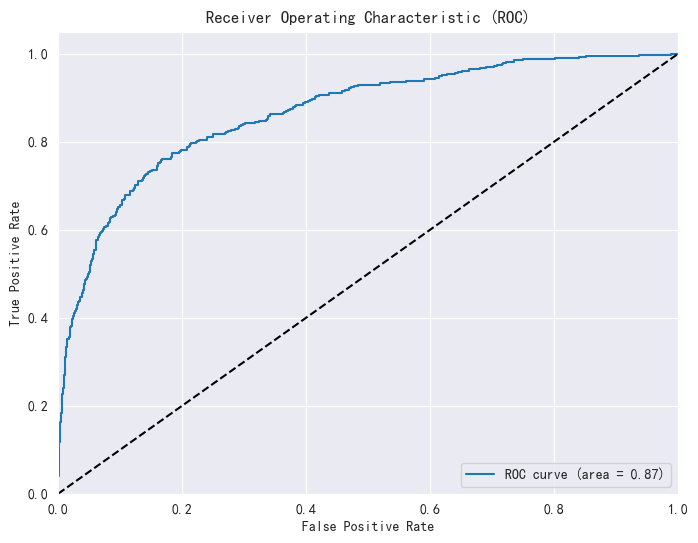

In [62]:
# 数据处理
df_sklearn = df.copy(deep=True)
df_sklearn['Gender'] = df_sklearn['Gender'].map({'Male':0,'Female':1})
# df_sklearn.info()

# 特征与目标变量
nfeatures = df_sklearn.iloc[:,2:-1] 
target = df_sklearn['Exited']

# 分割数据集
x_train,x_test,y_train,y_test = train_test_split(nfeatures,target,test_size=0.2,random_state=42)

# 预处理:数值特征标准化,类别特征OneHot编码
# 自动识别数据类型选取指定特征变量
numeric_features = nfeatures.select_dtypes(include=[np.number]).drop(columns=['Geography','Gender','HasCrCard','IsActiveMember'],errors='ignore').columns.tolist()
categorical_features = ['Geography','Gender','HasCrCard','IsActiveMember']
# 数值特征标准化的转换器定义
numeric_transformer = StandardScaler()
# 独热编码的转换器定义
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')
# 列变换器
# ColumnTransformer根据特征类型分别应用不同的变换器到数据集
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ]
)

# 预处理数据
# 应用预处理器对训练集进行拟合并转换.fit_transform会先根据训练数据学习必要的参数（比如StandardScaler的学习均值和方差），然后应用转换。
x_train_processed = preprocessor.fit_transform(x_train)
# 对测试集进行转换。因为预处理器已经通过训练集学会了转换规则，这里只需直接应用相同的转换规则到测试数据上。
x_test_processed = preprocessor.transform(x_test)

# 随机森立模型参数调优
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),param_grid,cv=5,scoring='roc_auc')
grid_search.fit(x_train_processed,y_train)

# 获取最佳参数
best_params = grid_search.best_params_
print('Best Parameters Found:',best_params)

# 使用最佳参数构建模型并训练
# **best_params解包字典为关键字参数,值传递给对应函数参数
optimized_rf = RandomForestClassifier(**best_params,random_state=42)
optimized_rf.fit(x_train_processed,y_train)

# 预测
predictions = optimized_rf.predict(x_test_processed)
# probs是输出正负类概率的二维数组,probs[:,1]是正类概率的一维数组
# pridict_proba()是随机森林分类器的一个方法,它接受一个特征数组作为输入，并返回每个样本属于各个类别的概率。这对于后续进ROC曲线绘制非常有用的。
probs = optimized_rf.predict_proba(x_test_processed)[:,1]

# 模型评估
accuracy = accuracy_score(y_test,predictions)
precision = precision_score(y_test,predictions)
recall = recall_score(y_test,predictions)
roc_auc = roc_auc_score(y_test, probs)

print(f'Accuracy:{accuracy}\n Precision:{precision}\n Recall:{recall}\n Roc_Auc:{roc_auc}')

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()